In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error  
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import optuna

/app/tmp1/anaconda/envs/nse-torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import re

In [4]:
from perform_visualization import perform_eda, perform_eda_short, performance_visualizations

In [5]:
random_seed = 42
early_stopping_round = 100

In [6]:
stat_path = os.path.join(os.getcwd())
pattern = re.compile(r'output_*\d')
folder_paths =[]
for folder_name in os.listdir(stat_path):
    if pattern.match(folder_name):
        folder_paths.append(folder_name)

In [7]:
specific_features= pd.DataFrame({"y": [500.0],
                                "z": [156.25],
                                "u": [7.5],
                                "power":[1.1],
                                "roughness": [0.1],
                                "T": [241.0],
                                "sensible_heat_flux":[-0.35],
                                "T_grad":[0.03],
                                "distances": [1054.6875]})

In [8]:
filename_features = "features_full.csv"
filename_target = "target_full.csv"

In [9]:
folder_paths = ["output_28_12_2024"]

In [10]:
X = pd.DataFrame()
y = pd.DataFrame()
for folder in folder_paths:
    X_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_features)
    y_tmp = pd.read_csv(os.getcwd() + "/" + folder + "/" + filename_target)
    
    is_unnamed = pd.isna(X_tmp.columns[0]) or str(X_tmp.columns[0]).startswith('Unnamed:')
    is_unnamed_y = pd.isna(y_tmp.columns[0]) or str(y_tmp.columns[0]).startswith('Unnamed:')
    if is_unnamed:
        X_tmp = X_tmp.drop(X_tmp.columns[0], axis=1)
    if is_unnamed_y:
        y_tmp = y_tmp.drop(y_tmp.columns[0], axis=1)
    
    if X_tmp.columns[0] != "y":
        col_y = np.ones(X_tmp.shape[0]) * 1000
        X_tmp.insert(0, "y", col_y)
    
    print(X_tmp.shape, y_tmp.shape)
    X = pd.concat([X, X_tmp], axis = 0)
    y = pd.concat([y, y_tmp], axis = 0)
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)
X.shape, y.shape

(1034880, 9) (1034880, 4)


((1034880, 9), (1034880, 4))

## Delete zeros

In [11]:
#Delete zeros
mask = (y["c_std_y"] != 0) & (y["c_std_z"] != 0)
X = X[mask]
y = y[mask]

In [12]:
points = np.linspace(0, np.max(y["c_std_y"]), 200)
quantiles = np.histogram(y["c_std_y"], points)
hist_mode = quantiles[1][np.argmax(quantiles[0])]

In [13]:
cut_mask = y["c_std_y"] >= hist_mode
X = X[cut_mask]
y = y[cut_mask]
X.shape, y.shape

((1007156, 9), (1007156, 4))

## EDA

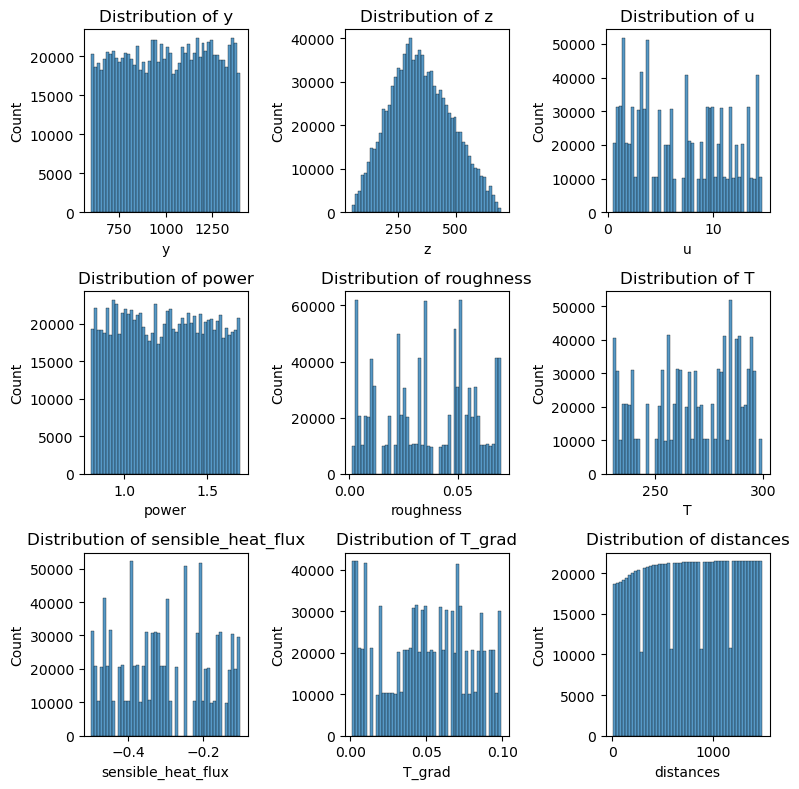

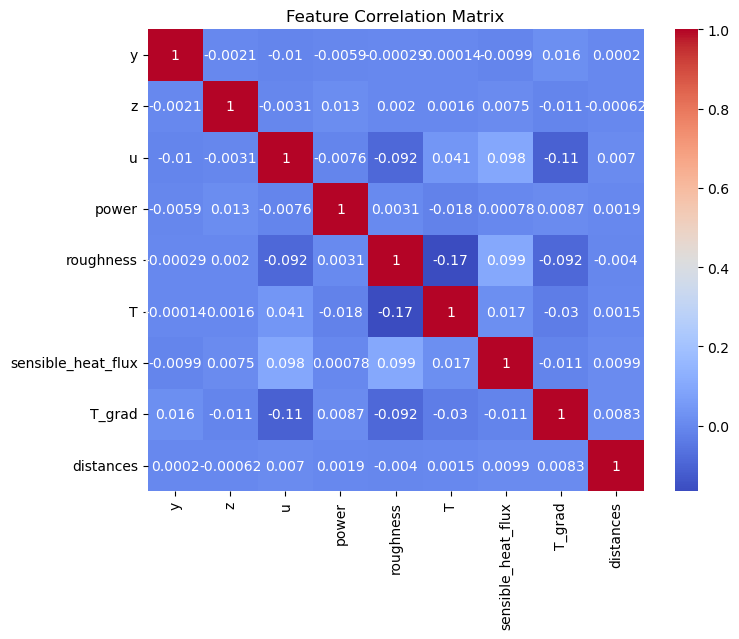

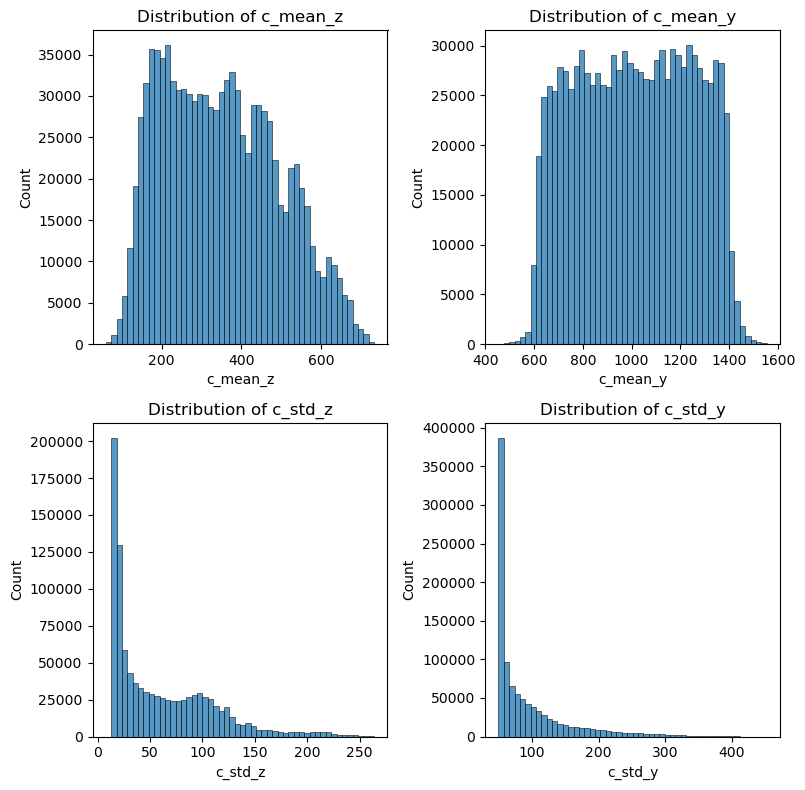

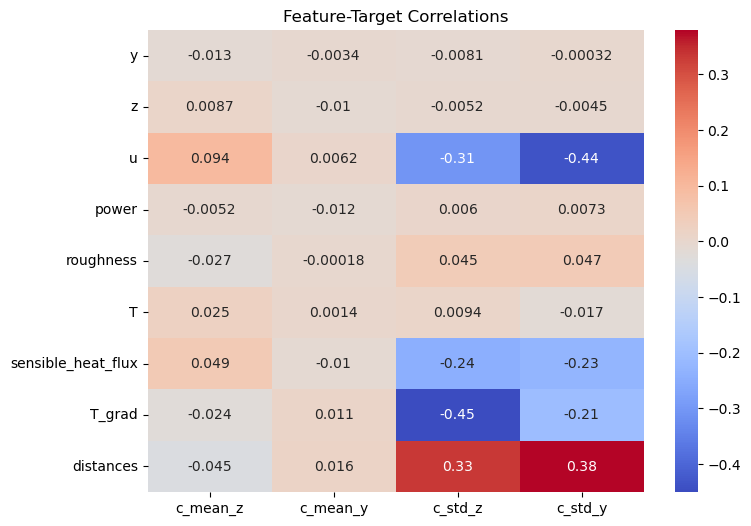

In [ ]:
# perform_eda(X, y)

## Test-train split

In [14]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

In [ ]:
# for small dataset
# X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
# X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=random_seed)

In [ ]:
# for small dataset
# X_train.shape, y_train.shape, X_eval.shape, y_eval.shape

((596090, 9), (596090, 4), (66233, 9), (66233, 4))

In [16]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_eval.shape, y_eval.shape

((580121, 9), (580121, 4), (161145, 9), (161145, 4), (64458, 9), (64458, 4))

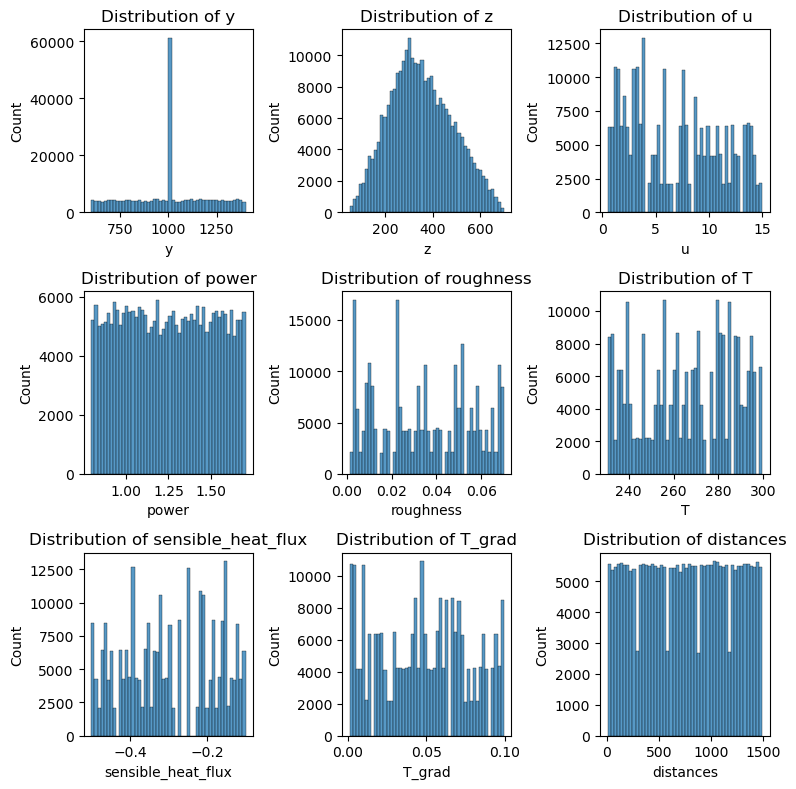

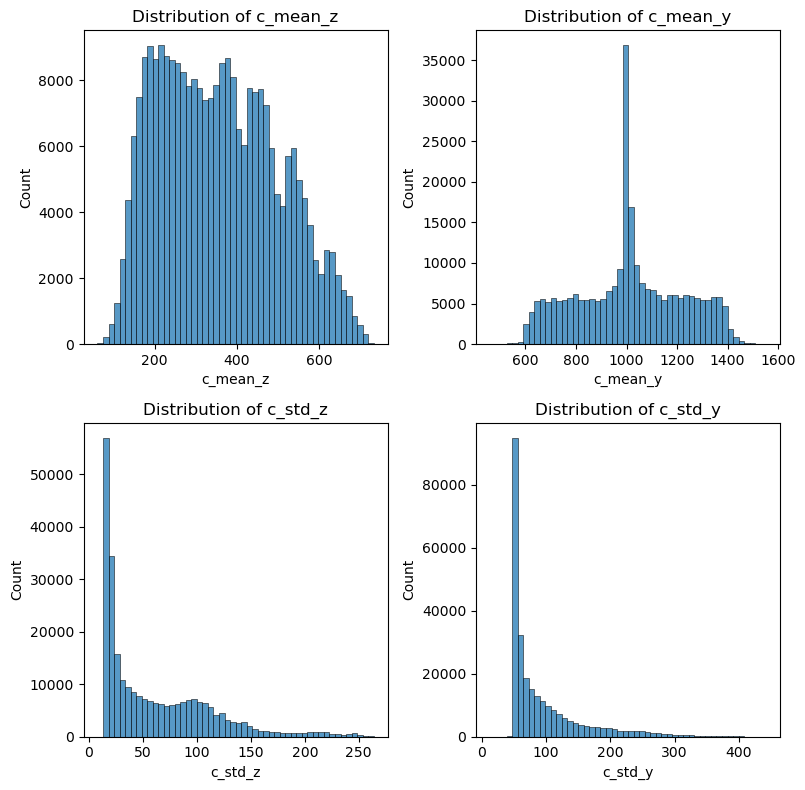

In [ ]:
# perform_eda_short(X_test, y_test)

## Feature engineering

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import quantile_transform, power_transform

In [18]:
class TargetPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, near_zero = 1e-1):
        self.near_zero = near_zero

    def fit(self, data: pd.DataFrame, *args):
        self.columns = data.columns
        self.std_y_bias = np.min(data["c_std_y"])
        self.std_z_bias = np.min(data["c_std_z"])
        
        self.std_y_std = np.std(data["c_std_y"])
        self.std_z_std = np.std(data["c_std_z"])

        self.mean_y_mean = np.mean(data["c_mean_y"])
        self.mean_z_mean = np.mean(data["c_mean_z"])

        self.mean_y_std = np.std(data["c_mean_y"])
        self.mean_z_std = np.std(data["c_mean_z"])

        return self

    def transform(self, data: pd.DataFrame):
        data["c_std_y"] -= self.std_y_bias - self.near_zero
        data["c_std_z"] -= self.std_z_bias - self.near_zero
        data["c_std_y"] = np.log(data["c_std_y"])
        data["c_std_z"] = np.log1p(data["c_std_z"])

        # data["c_mean_y"] -= self.mean_y_mean
        # data["c_mean_y"] /= self.mean_y_std
        # mean_y_sign =  np.sign(data["c_mean_y"])
        # self.mean_y_sign = mean_y_sign
        # data["c_mean_y"] = np.abs(data["c_mean_y"])        
        # data["c_mean_y"] = np.log(data["c_mean_y"])

        # # points = np.linspace(0, np.max(data["c_mean_y"]), 200)
        # # quantiles = np.histogram(data["c_mean_y"], points)
        # # quantile_big = quantiles[1][np.argmax(quantiles[0])]
        # # self.mean_y_log_mode = quantile_big

        # # data["c_mean_y"] -= self.mean_y_log_mode
        # data["c_mean_y"] *=mean_y_sign
        data["c_mean_y"] = (data["c_mean_y"] - self.mean_y_mean)/self.mean_y_std
        data["c_mean_z"] = (data["c_mean_z"] - self.mean_z_mean)/self.mean_z_std
        return data
    
    def inverse_transform(self, data: pd.DataFrame):
      
        data["c_std_y"] = np.exp(data["c_std_y"])
        data["c_std_z"] = np.exp(data["c_std_z"])
        data["c_std_y"] += self.std_y_bias - self.near_zero
        data["c_std_z"] += self.std_z_bias - self.near_zero
        
        # mean_y_sign = np.sign(data["c_mean_y"])
        # data["c_mean_y"] *= self.mean_y_sign
        # data["c_mean_y"] = np.exp(data["c_mean_y"])
        # data["c_mean_y"] *= mean_y_sign
        # data["c_mean_y"] *=self.mean_y_std
        # data["c_mean_y"] += self.mean_y_mean
        data["c_mean_y"] = data["c_mean_y"] * self.mean_y_std + self.mean_y_mean
        data["c_mean_z"] = data["c_mean_z"] * self.mean_z_std + self.mean_z_mean
        return data


In [18]:
# y_train_1 = y_train.copy()
# target_pr = TargetPreprocessor()
# target_pr.fit(y_train_1)
# target_pr.transform(y_train_1)
# y_eval_1 = y_eval.copy()
# target_pr.transform(y_eval_1)
# target_pr.transform(y_valid)

In [19]:
t_preproc = TargetPreprocessor()
t_preproc.fit(pd.concat([y, y_test]))
t_preproc.transform(y_train)
# perform_eda_short(X_train, y_train)

,c_mean_z,c_mean_y,c_std_z,c_std_y
408802,-0.296936,-1.191829,2.998442,1.713472
656404,0.347983,1.030342,3.790911,3.410347
45059,0.208929,-0.591985,2.407042,1.952551
821414,-0.835757,1.653144,4.286303,3.205944
676593,-1.297746,1.287611,4.501083,5.412012
...,...,...,...,...
271786,-0.235894,-0.028195,2.544058,0.100914
818718,2.185465,-0.729186,2.531440,0.323958
646623,0.427708,1.279481,4.788934,3.757557
607494,-1.741624,-1.058817,3.043944,0.882550


In [20]:
t_preproc.transform(y_eval)
t_preproc.transform(y_valid)

,c_mean_z,c_mean_y,c_std_z,c_std_y
298816,0.202694,-1.561703,3.611829,3.793113
385835,-0.475684,-0.344906,3.888531,2.651383
806534,2.300088,-1.674679,4.832276,4.395210
844295,0.634432,0.776413,2.347855,0.441209
127380,-1.231244,-1.373979,4.564309,5.052230
...,...,...,...,...
974353,1.527881,1.285681,2.672425,-0.493233
922526,-0.434398,0.826959,3.798036,3.335165
331760,-0.921078,-0.281381,4.605490,4.544696
362711,-1.422943,-1.729531,4.048872,3.122934


## Models

## Catboost with optuna

In [21]:
def objective(trial):
    param = {
        'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.02),
        'depth': trial.suggest_int('depth', 1, 16),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 3.0),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32]),
        'grow_policy': 'SymmetricTree',
        'iterations': 300,
        'use_best_model': True,
        'eval_metric': 'MultiRMSE',
        'loss_function': 'MultiRMSE',
        'od_type': 'iter',
        'task_type': "GPU",
        # 'devices': '0',
        'od_wait': 20,
        'random_state': random_seed,
        'logging_level': 'Silent'
    }
    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_eval.copy(), y_eval.copy())],
                  early_stopping_rounds=early_stopping_round)
    loss = root_mean_squared_error(y_valid, regressor.predict(X_valid.copy()))
    return loss

In [22]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{random_seed}')
study.optimize(objective, n_trials=1000, timeout=7200)

[I 2025-02-16 10:21:24,818] A new study created in memory with name: catboost-seed42
[I 2025-02-16 10:21:26,712] Trial 0 finished with value: 1.074680284729719 and parameters: {'learning_rate': 0.004530396084633039, 'depth': 2, 'l2_leaf_reg': 2.473710746170334, 'min_child_samples': 16}. Best is trial 0 with value: 1.074680284729719.
[I 2025-02-16 10:21:29,554] Trial 1 finished with value: 0.9544458894008598 and parameters: {'learning_rate': 0.017141258641516766, 'depth': 7, 'l2_leaf_reg': 0.03249882822213268, 'min_child_samples': 8}. Best is trial 1 with value: 0.9544458894008598.
[I 2025-02-16 10:21:35,964] Trial 2 finished with value: 0.9369757077372605 and parameters: {'learning_rate': 0.011724861466946769, 'depth': 10, 'l2_leaf_reg': 2.1918303623010695, 'min_child_samples': 1}. Best is trial 2 with value: 0.9369757077372605.
[I 2025-02-16 10:21:37,455] Trial 3 finished with value: 1.0618770688616685 and parameters: {'learning_rate': 0.011126219134894762, 'depth': 1, 'l2_leaf_reg': 

: 

In [ ]:
print(study.best_value)
print(study.best_params)

In [13]:
best_params = {'learning_rate': 0.0199640131584563, 'depth': 15, 'l2_leaf_reg': 1.8809696508799658, 'min_child_samples': 16}

In [14]:
params = {
    "learning_rate": best_params['learning_rate'],
    "depth": best_params['depth'],
    "l2_leaf_reg": best_params['l2_leaf_reg'],
    "min_child_samples": best_params['min_child_samples'],
    "grow_policy": 'Depthwise',
    "iterations": 1000,
    "use_best_model": True,
    "eval_metric": 'RMSE',
    "loss_function": 'RMSE',
    # "thread_count": -1,
    "od_type": 'iter',
    "od_wait": 20,
    "task_type":"GPU",
    # "devices":'0',
    "random_state": random_seed,
    "logging_level": 'Silent'
}   

In [15]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler

In [16]:
%%time
y_pred ={}
regressors = {}
for target in ["c_mean_y", "c_mean_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)

    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor
for target in ["c_std_y", "c_std_z"]:
    
    optimized_regressor = CatBoostRegressor(**params)
    
    optimized_regressor.fit(X_train.copy(), y_train[target].copy(),
                            eval_set=[(X_eval.copy(), y_eval[target].copy())],
                            early_stopping_rounds=early_stopping_round)
    y_pred_tmp = optimized_regressor.predict(X_test.copy())
    y_pred[target] = y_pred_tmp
    regressors[target] = optimized_regressor

KeyboardInterrupt: 

In [ ]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

array([[<Axes: title={'center': 'c_mean_y'}>,
        <Axes: title={'center': 'c_mean_z'}>],
       [<Axes: title={'center': 'c_std_y'}>,
        <Axes: title={'center': 'c_std_z'}>]], dtype=object)

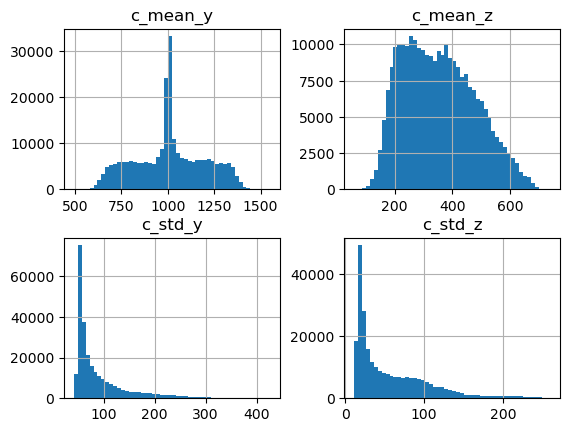

In [ ]:
pd.DataFrame.from_dict(y_pred).hist(bins=100)

In [66]:
print(regressors["c_mean_y"].predict(specific_features))
print(regressors["c_std_y"].predict(specific_features))

[971.24424704]
[4.46791407]


## Random Forest

In [20]:
model_rf = RandomForestRegressor(n_jobs=64)

In [21]:
y_pred = {}
for target in y_train.columns:
    model_rf.fit(X_train, y_train[target])
    y_tmp = model_rf.predict(X_test)
    y_pred[target] = y_tmp

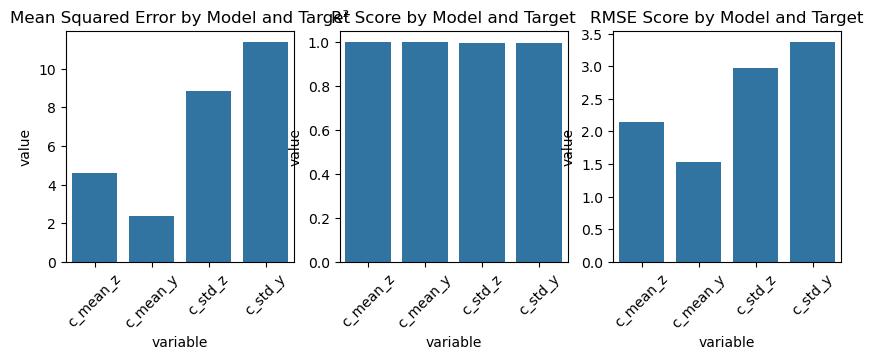

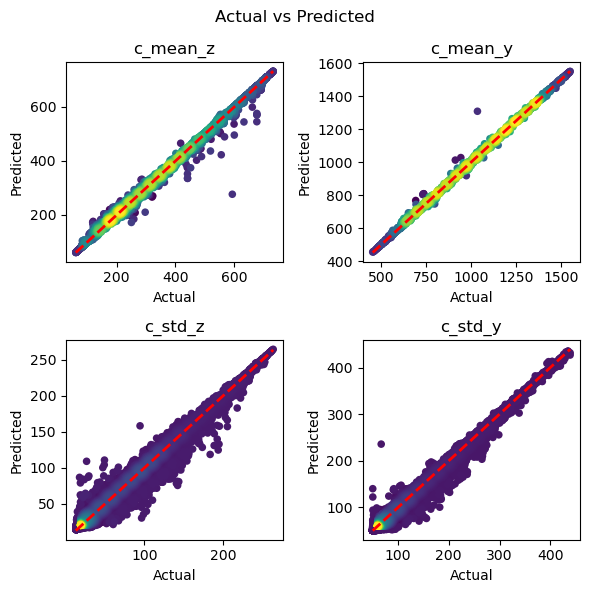

                mse        r2      rmse
c_mean_z   4.613955  0.999775  2.148012
c_mean_y   2.354560  0.999956  1.534458
c_std_z    8.849461  0.996221  2.974804
c_std_y   11.383457  0.996754  3.373938


In [22]:
t_preproc.inverse_transform(y_pred)
performance_visualizations(y_pred, y_test)

array([[<Axes: title={'center': 'c_mean_z'}>,
        <Axes: title={'center': 'c_mean_y'}>],
       [<Axes: title={'center': 'c_std_z'}>,
        <Axes: title={'center': 'c_std_y'}>]], dtype=object)

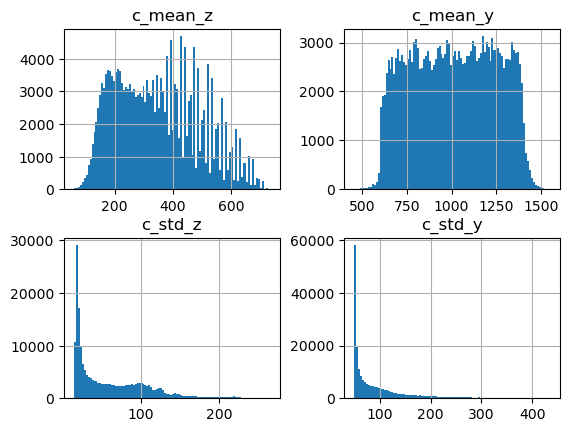

In [23]:
pd.DataFrame.from_dict(y_pred).hist(bins=100)